In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
cd /content/drive/MyDrive/UNet/dataset

/content/drive/MyDrive/UNet/dataset


In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt

In [ ]:
train_dir = "/content/drive/MyDrive/UNet/dataset/train"
valid_dir = "/content/drive/MyDrive/UNet/dataset/valid"
test_dir = "/content/drive/MyDrive/UNet/dataset/test"

In [ ]:
IMG_SIZE = (256, 256)
BATCH_SIZE = 16

In [ ]:
# Mapping warna ke kelas
COLOR_MAP = {
    (0, 255, 255): 0,  # urban_land
    (255, 255, 0): 1,  # agriculture_land
    (255, 0, 255): 2,  # rangeland
    (0, 255, 0): 3,  # forest_land
    (0, 0, 255): 4,  # water
    (255, 255, 255): 5,  # barren_land
    (0, 0, 0): 6  # unknown
}


In [ ]:
def rgb_to_label(mask):
    label_mask = np.zeros((mask.shape[0], mask.shape[1]), dtype=np.uint8)
    for rgb, label in COLOR_MAP.items():
        mask_match = np.all(mask == np.array(rgb), axis=-1)
        label_mask[mask_match] = label
    return label_mask
# Fungsi untuk memuat gambar dan mask multi-kelas
def load_data(image_dir, mask_dir=None):
    images = []
    masks = [] if mask_dir else None


    for filename in os.listdir(image_dir):
        if "_sat.jpg" in filename:
            img_path = os.path.join(image_dir, filename)
            img = load_img(img_path, target_size=IMG_SIZE)
            img = img_to_array(img) / 255.0  # Normalisasi
            images.append(img)


            if mask_dir:
                mask_filename = filename.replace("_sat.jpg", "_mask.png")
                mask_path = os.path.join(mask_dir, mask_filename)
                if os.path.exists(mask_path):
                    mask = load_img(mask_path, target_size=IMG_SIZE)
                    mask = img_to_array(mask).astype(np.uint8)
                    mask = rgb_to_label(mask)  # Konversi ke indeks kelas
                    masks.append(mask)


    images = np.array(images)
    masks = np.array(masks) if masks is not None else None
    if masks is not None:
        masks = masks[..., np.newaxis]  # Tambahkan dimensi channel


    return images, masks


In [ ]:
# Load dataset
X_train, Y_train = load_data(train_dir, train_dir)
X_valid, Y_valid = load_data(valid_dir, valid_dir)
X_test, _ = load_data(test_dir)  # Tidak ada mask di test

In [ ]:
X_train.shape, Y_train.shape, X_valid.shape, Y_valid.shape, X_test.shape

((643, 256, 256, 3),
 (643, 256, 256, 1),
 (160, 256, 256, 3),
 (160, 256, 256, 1),
 (172, 256, 256, 3))

In [ ]:
# Definisi model U-Net
def unet_model(input_shape=(256, 256, 3), num_classes=7):  # 7 kelas berdasarkan mask
    inputs = layers.Input(input_shape)


    # Encoder
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)


    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)


    # Bottleneck
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c3)


    # Decoder
    u4 = layers.UpSampling2D((2, 2))(c3)
    u4 = layers.concatenate([u4, c2])  # Skip connection dari c2
    c4 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u4)
    c4 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c4)


    u5 = layers.UpSampling2D((2, 2))(c4)
    u5 = layers.concatenate([u5, c1])  # Skip connection dari c1
    c5 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u5)
    c5 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c5)


    outputs = layers.Conv2D(num_classes, (1, 1), activation='softmax')(c5)  # Softmax untuk multi-kelas


    model = keras.Model(inputs, outputs)
    return model



In [ ]:
num_classes = 7
model = unet_model(num_classes=num_classes)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 256, 256, 64)   │          1,792 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 256, 256, 64)   │         36,928 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 128, 128, 64)   │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 128, 128, 128)  │         73,856 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 128, 128, 128)  │        147,584 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 64, 64, 128)    │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 64, 64, 256)    │        295,168 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 64, 64, 256)    │        590,080 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ up_sampling2d             │ (None, 128, 128, 256)  │              0 │ conv2d_5[0][0]         │
│ (UpSampling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 128, 128, 384)  │              0 │ up_sampling2d[0][0],   │
│                           │                        │                │ conv2d_3[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 128, 128, 128)  │        442,496 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 128, 128, 128)  │        147,584 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ up_sampling2d_1           │ (None, 256, 256, 128)  │              0 │ conv2d_7[0][0]         │
│ (UpSampling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_1             │ (None, 256, 256, 192)  │              0 │ up_sampling2d_1[0][0], │
│ (Concatenate)             │                        │                │ conv2d_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 256, 256, 64)   │        110,656 │ concatenate_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_9 (Conv2D)    

 Total params: 1,883,527 (7.19 MB)

 Trainable params: 1,883,527 (7.19 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Menyimpan nilai terbaik
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Simpan model terbaik berdasarkan val_loss
checkpoint_callback_best = ModelCheckpoint(
    '/content/drive/MyDrive/UNet/model/best_model_unet_optimasi.h5',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

# Gunakan Adam optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

# Compile model
model.compile(
    optimizer=optimizer,
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

history = model.fit(
    X_train, Y_train,
    epochs=100,
    batch_size=BATCH_SIZE,
    validation_data=(X_valid, Y_valid),
    callbacks=[checkpoint_callback_best]
)

Epoch 1/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 511ms/step - accuracy: 0.7131 - loss: 0.9171
Epoch 1: val_loss improved from inf to 0.92406, saving model to /content/drive/MyDrive/UNet/model/best_model_unet_optimasi.h5


41/41 ━━━━━━━━━━━━━━━━━━━━ 31s 602ms/step - accuracy: 0.7135 - loss: 0.9155 - val_accuracy: 0.6968 - val_loss: 0.9241
Epoch 2/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step - accuracy: 0.7427 - loss: 0.7899
Epoch 2: val_loss improved from 0.92406 to 0.82428, saving model to /content/drive/MyDrive/UNet/model/best_model_unet_optimasi.h5


41/41 ━━━━━━━━━━━━━━━━━━━━ 36s 536ms/step - accuracy: 0.7426 - loss: 0.7899 - val_accuracy: 0.7233 - val_loss: 0.8243
Epoch 3/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step - accuracy: 0.7436 - loss: 0.7782
Epoch 3: val_loss did not improve from 0.82428
41/41 ━━━━━━━━━━━━━━━━━━━━ 22s 524ms/step - accuracy: 0.7436 - loss: 0.7782 - val_accuracy: 0.7051 - val_loss: 0.8616
Epoch 4/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 471ms/step - accuracy: 0.7410 - loss: 0.7911
Epoch 4: val_loss did not improve from 0.82428
41/41 ━━━━━━━━━━━━━━━━━━━━ 41s 536ms/step - accuracy: 0.7409 - loss: 0.7913 - val_accuracy: 0.7107 - val_loss: 0.8647
Epoch 5/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 473ms/step - accuracy: 0.7257 - loss: 0.8277
Epoch 5: val_loss improved from 0.82428 to 0.80937, saving model to /content/drive/MyDrive/UNet/model/best_model_unet_optimasi.h5


41/41 ━━━━━━━━━━━━━━━━━━━━ 42s 562ms/step - accuracy: 0.7257 - loss: 0.8274 - val_accuracy: 0.7299 - val_loss: 0.8094
Epoch 6/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 474ms/step - accuracy: 0.7507 - loss: 0.7503
Epoch 6: val_loss improved from 0.80937 to 0.80114, saving model to /content/drive/MyDrive/UNet/model/best_model_unet_optimasi.h5


41/41 ━━━━━━━━━━━━━━━━━━━━ 23s 563ms/step - accuracy: 0.7509 - loss: 0.7499 - val_accuracy: 0.7295 - val_loss: 0.8011
Epoch 7/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 465ms/step - accuracy: 0.7651 - loss: 0.6921
Epoch 7: val_loss did not improve from 0.80114
41/41 ━━━━━━━━━━━━━━━━━━━━ 40s 529ms/step - accuracy: 0.7651 - loss: 0.6923 - val_accuracy: 0.7295 - val_loss: 0.8019
Epoch 8/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms/step - accuracy: 0.7724 - loss: 0.6906
Epoch 8: val_loss did not improve from 0.80114
41/41 ━━━━━━━━━━━━━━━━━━━━ 22s 545ms/step - accuracy: 0.7720 - loss: 0.6915 - val_accuracy: 0.7064 - val_loss: 0.8721
Epoch 9/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 473ms/step - accuracy: 0.7577 - loss: 0.7162
Epoch 9: val_loss did not improve from 0.80114
41/41 ━━━━━━━━━━━━━━━━━━━━ 21s 514ms/step - accuracy: 0.7579 - loss: 0.7159 - val_accuracy: 0.6990 - val_loss: 0.8520
Epoch 10/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step - accuracy: 0.7561 - loss: 0.7200
Epoch 10: val_loss did not improve fro

41/41 ━━━━━━━━━━━━━━━━━━━━ 42s 529ms/step - accuracy: 0.7580 - loss: 0.7035 - val_accuracy: 0.7442 - val_loss: 0.7589
Epoch 12/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms/step - accuracy: 0.7518 - loss: 0.7342
Epoch 12: val_loss did not improve from 0.75892
41/41 ━━━━━━━━━━━━━━━━━━━━ 22s 545ms/step - accuracy: 0.7521 - loss: 0.7335 - val_accuracy: 0.7312 - val_loss: 0.8214
Epoch 13/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step - accuracy: 0.7686 - loss: 0.6894
Epoch 13: val_loss did not improve from 0.75892
41/41 ━━━━━━━━━━━━━━━━━━━━ 40s 531ms/step - accuracy: 0.7688 - loss: 0.6891 - val_accuracy: 0.7492 - val_loss: 0.7733
Epoch 14/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 478ms/step - accuracy: 0.7792 - loss: 0.6653
Epoch 14: val_loss did not improve from 0.75892
41/41 ━━━━━━━━━━━━━━━━━━━━ 41s 521ms/step - accuracy: 0.7792 - loss: 0.6653 - val_accuracy: 0.6640 - val_loss: 0.9430
Epoch 15/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step - accuracy: 0.7655 - loss: 0.6975
Epoch 15: val_loss did not impro

41/41 ━━━━━━━━━━━━━━━━━━━━ 22s 543ms/step - accuracy: 0.7725 - loss: 0.6824 - val_accuracy: 0.7579 - val_loss: 0.7312
Epoch 17/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 464ms/step - accuracy: 0.7862 - loss: 0.6429
Epoch 17: val_loss did not improve from 0.73125
41/41 ━━━━━━━━━━━━━━━━━━━━ 40s 507ms/step - accuracy: 0.7861 - loss: 0.6430 - val_accuracy: 0.7235 - val_loss: 0.7897
Epoch 18/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 478ms/step - accuracy: 0.7747 - loss: 0.6597
Epoch 18: val_loss did not improve from 0.73125
41/41 ━━━━━━━━━━━━━━━━━━━━ 42s 521ms/step - accuracy: 0.7750 - loss: 0.6591 - val_accuracy: 0.7493 - val_loss: 0.7436
Epoch 19/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step - accuracy: 0.7926 - loss: 0.6216
Epoch 19: val_loss improved from 0.73125 to 0.70128, saving model to /content/drive/MyDrive/UNet/model/best_model_unet_optimasi.h5


41/41 ━━━━━━━━━━━━━━━━━━━━ 23s 572ms/step - accuracy: 0.7924 - loss: 0.6218 - val_accuracy: 0.7610 - val_loss: 0.7013
Epoch 20/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step - accuracy: 0.7840 - loss: 0.6383
Epoch 20: val_loss did not improve from 0.70128
41/41 ━━━━━━━━━━━━━━━━━━━━ 22s 531ms/step - accuracy: 0.7838 - loss: 0.6387 - val_accuracy: 0.7290 - val_loss: 0.8500
Epoch 21/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step - accuracy: 0.7675 - loss: 0.6861
Epoch 21: val_loss did not improve from 0.70128
41/41 ━━━━━━━━━━━━━━━━━━━━ 41s 531ms/step - accuracy: 0.7678 - loss: 0.6852 - val_accuracy: 0.7578 - val_loss: 0.7157
Epoch 22/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step - accuracy: 0.7878 - loss: 0.6347
Epoch 22: val_loss did not improve from 0.70128
41/41 ━━━━━━━━━━━━━━━━━━━━ 41s 541ms/step - accuracy: 0.7878 - loss: 0.6347 - val_accuracy: 0.7696 - val_loss: 0.7115
Epoch 23/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step - accuracy: 0.7959 - loss: 0.6031
Epoch 23: val_loss improved from

41/41 ━━━━━━━━━━━━━━━━━━━━ 42s 559ms/step - accuracy: 0.7956 - loss: 0.6039 - val_accuracy: 0.7726 - val_loss: 0.6681
Epoch 24/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 473ms/step - accuracy: 0.7927 - loss: 0.6111
Epoch 24: val_loss did not improve from 0.66809
41/41 ━━━━━━━━━━━━━━━━━━━━ 39s 515ms/step - accuracy: 0.7925 - loss: 0.6115 - val_accuracy: 0.7539 - val_loss: 0.7257
Epoch 25/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 481ms/step - accuracy: 0.7853 - loss: 0.6334
Epoch 25: val_loss did not improve from 0.66809
41/41 ━━━━━━━━━━━━━━━━━━━━ 21s 523ms/step - accuracy: 0.7854 - loss: 0.6333 - val_accuracy: 0.7653 - val_loss: 0.6927
Epoch 26/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 469ms/step - accuracy: 0.7892 - loss: 0.6208
Epoch 26: val_loss did not improve from 0.66809
41/41 ━━━━━━━━━━━━━━━━━━━━ 21s 511ms/step - accuracy: 0.7892 - loss: 0.6206 - val_accuracy: 0.7564 - val_loss: 0.7291
Epoch 27/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 465ms/step - accuracy: 0.8006 - loss: 0.5864
Epoch 27: val_loss did not impro

41/41 ━━━━━━━━━━━━━━━━━━━━ 42s 539ms/step - accuracy: 0.7690 - loss: 0.6689 - val_accuracy: 0.7738 - val_loss: 0.6675
Epoch 31/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step - accuracy: 0.7911 - loss: 0.6052
Epoch 31: val_loss did not improve from 0.66754
41/41 ━━━━━━━━━━━━━━━━━━━━ 40s 514ms/step - accuracy: 0.7912 - loss: 0.6049 - val_accuracy: 0.7647 - val_loss: 0.6975
Epoch 32/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 473ms/step - accuracy: 0.7970 - loss: 0.5884
Epoch 32: val_loss did not improve from 0.66754
41/41 ━━━━━━━━━━━━━━━━━━━━ 41s 516ms/step - accuracy: 0.7970 - loss: 0.5883 - val_accuracy: 0.7627 - val_loss: 0.6885
Epoch 33/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 471ms/step - accuracy: 0.7955 - loss: 0.5938
Epoch 33: val_loss did not improve from 0.66754
41/41 ━━━━━━━━━━━━━━━━━━━━ 41s 514ms/step - accuracy: 0.7955 - loss: 0.5938 - val_accuracy: 0.7736 - val_loss: 0.6690
Epoch 34/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step - accuracy: 0.7997 - loss: 0.5874
Epoch 34: val_loss did not impro

41/41 ━━━━━━━━━━━━━━━━━━━━ 41s 536ms/step - accuracy: 0.8061 - loss: 0.5599 - val_accuracy: 0.7787 - val_loss: 0.6502
Epoch 36/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 471ms/step - accuracy: 0.8138 - loss: 0.5569
Epoch 36: val_loss did not improve from 0.65019
41/41 ━━━━━━━━━━━━━━━━━━━━ 40s 514ms/step - accuracy: 0.8136 - loss: 0.5571 - val_accuracy: 0.7741 - val_loss: 0.6660
Epoch 37/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 474ms/step - accuracy: 0.8050 - loss: 0.5667
Epoch 37: val_loss improved from 0.65019 to 0.62940, saving model to /content/drive/MyDrive/UNet/model/best_model_unet_optimasi.h5


41/41 ━━━━━━━━━━━━━━━━━━━━ 43s 569ms/step - accuracy: 0.8051 - loss: 0.5663 - val_accuracy: 0.7863 - val_loss: 0.6294
Epoch 38/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 471ms/step - accuracy: 0.8196 - loss: 0.5299
Epoch 38: val_loss did not improve from 0.62940
41/41 ━━━━━━━━━━━━━━━━━━━━ 40s 536ms/step - accuracy: 0.8194 - loss: 0.5303 - val_accuracy: 0.7684 - val_loss: 0.7214
Epoch 39/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 475ms/step - accuracy: 0.7943 - loss: 0.5936
Epoch 39: val_loss did not improve from 0.62940
41/41 ━━━━━━━━━━━━━━━━━━━━ 40s 517ms/step - accuracy: 0.7946 - loss: 0.5928 - val_accuracy: 0.7716 - val_loss: 0.6988
Epoch 40/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step - accuracy: 0.8066 - loss: 0.5710
Epoch 40: val_loss did not improve from 0.62940
41/41 ━━━━━━━━━━━━━━━━━━━━ 22s 541ms/step - accuracy: 0.8065 - loss: 0.5710 - val_accuracy: 0.7842 - val_loss: 0.6360
Epoch 41/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 465ms/step - accuracy: 0.8203 - loss: 0.5148
Epoch 41: val_loss improved from

41/41 ━━━━━━━━━━━━━━━━━━━━ 41s 549ms/step - accuracy: 0.8202 - loss: 0.5151 - val_accuracy: 0.7944 - val_loss: 0.6024
Epoch 42/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 478ms/step - accuracy: 0.8220 - loss: 0.5157
Epoch 42: val_loss did not improve from 0.60238
41/41 ━━━━━━━━━━━━━━━━━━━━ 40s 521ms/step - accuracy: 0.8219 - loss: 0.5160 - val_accuracy: 0.7891 - val_loss: 0.6040
Epoch 43/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step - accuracy: 0.7981 - loss: 0.5602
Epoch 43: val_loss improved from 0.60238 to 0.59333, saving model to /content/drive/MyDrive/UNet/model/best_model_unet_optimasi.h5


41/41 ━━━━━━━━━━━━━━━━━━━━ 42s 553ms/step - accuracy: 0.7985 - loss: 0.5595 - val_accuracy: 0.7939 - val_loss: 0.5933
Epoch 44/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 479ms/step - accuracy: 0.8133 - loss: 0.5321
Epoch 44: val_loss did not improve from 0.59333
41/41 ━━━━━━━━━━━━━━━━━━━━ 22s 544ms/step - accuracy: 0.8132 - loss: 0.5324 - val_accuracy: 0.7755 - val_loss: 0.6491
Epoch 45/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step - accuracy: 0.8104 - loss: 0.5416
Epoch 45: val_loss did not improve from 0.59333
41/41 ━━━━━━━━━━━━━━━━━━━━ 40s 508ms/step - accuracy: 0.8106 - loss: 0.5412 - val_accuracy: 0.7775 - val_loss: 0.6573
Epoch 46/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step - accuracy: 0.8332 - loss: 0.4868
Epoch 46: val_loss did not improve from 0.59333
41/41 ━━━━━━━━━━━━━━━━━━━━ 42s 542ms/step - accuracy: 0.8328 - loss: 0.4878 - val_accuracy: 0.7624 - val_loss: 0.6840
Epoch 47/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 471ms/step - accuracy: 0.8011 - loss: 0.5815
Epoch 47: val_loss did not impro

41/41 ━━━━━━━━━━━━━━━━━━━━ 42s 555ms/step - accuracy: 0.8240 - loss: 0.4932 - val_accuracy: 0.8020 - val_loss: 0.5891
Epoch 55/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 478ms/step - accuracy: 0.8369 - loss: 0.4632
Epoch 55: val_loss improved from 0.58909 to 0.58815, saving model to /content/drive/MyDrive/UNet/model/best_model_unet_optimasi.h5


41/41 ━━━━━━━━━━━━━━━━━━━━ 40s 541ms/step - accuracy: 0.8368 - loss: 0.4635 - val_accuracy: 0.7935 - val_loss: 0.5882
Epoch 56/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step - accuracy: 0.8349 - loss: 0.4685
Epoch 56: val_loss improved from 0.58815 to 0.58106, saving model to /content/drive/MyDrive/UNet/model/best_model_unet_optimasi.h5


41/41 ━━━━━━━━━━━━━━━━━━━━ 23s 562ms/step - accuracy: 0.8349 - loss: 0.4685 - val_accuracy: 0.7980 - val_loss: 0.5811
Epoch 57/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 465ms/step - accuracy: 0.8327 - loss: 0.4833
Epoch 57: val_loss did not improve from 0.58106
41/41 ━━━━━━━━━━━━━━━━━━━━ 39s 507ms/step - accuracy: 0.8326 - loss: 0.4833 - val_accuracy: 0.7924 - val_loss: 0.5941
Epoch 58/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 479ms/step - accuracy: 0.8366 - loss: 0.4580
Epoch 58: val_loss did not improve from 0.58106
41/41 ━━━━━━━━━━━━━━━━━━━━ 42s 522ms/step - accuracy: 0.8367 - loss: 0.4579 - val_accuracy: 0.7954 - val_loss: 0.5909
Epoch 59/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 471ms/step - accuracy: 0.8328 - loss: 0.4754
Epoch 59: val_loss improved from 0.58106 to 0.57581, saving model to /content/drive/MyDrive/UNet/model/best_model_unet_optimasi.h5


41/41 ━━━━━━━━━━━━━━━━━━━━ 41s 535ms/step - accuracy: 0.8328 - loss: 0.4755 - val_accuracy: 0.8020 - val_loss: 0.5758
Epoch 60/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 474ms/step - accuracy: 0.8375 - loss: 0.4583
Epoch 60: val_loss did not improve from 0.57581
41/41 ━━━━━━━━━━━━━━━━━━━━ 40s 517ms/step - accuracy: 0.8375 - loss: 0.4583 - val_accuracy: 0.7542 - val_loss: 0.6908
Epoch 61/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 474ms/step - accuracy: 0.8294 - loss: 0.4794
Epoch 61: val_loss did not improve from 0.57581
41/41 ━━━━━━━━━━━━━━━━━━━━ 42s 538ms/step - accuracy: 0.8294 - loss: 0.4793 - val_accuracy: 0.7914 - val_loss: 0.6321
Epoch 62/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 479ms/step - accuracy: 0.8381 - loss: 0.4571
Epoch 62: val_loss improved from 0.57581 to 0.57103, saving model to /content/drive/MyDrive/UNet/model/best_model_unet_optimasi.h5


41/41 ━━━━━━━━━━━━━━━━━━━━ 22s 544ms/step - accuracy: 0.8381 - loss: 0.4570 - val_accuracy: 0.8027 - val_loss: 0.5710
Epoch 63/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step - accuracy: 0.8527 - loss: 0.4167
Epoch 63: val_loss did not improve from 0.57103
41/41 ━━━━━━━━━━━━━━━━━━━━ 40s 508ms/step - accuracy: 0.8525 - loss: 0.4171 - val_accuracy: 0.7972 - val_loss: 0.6077
Epoch 64/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 481ms/step - accuracy: 0.8408 - loss: 0.4367
Epoch 64: val_loss did not improve from 0.57103
41/41 ━━━━━━━━━━━━━━━━━━━━ 21s 524ms/step - accuracy: 0.8408 - loss: 0.4367 - val_accuracy: 0.7900 - val_loss: 0.6166
Epoch 65/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 475ms/step - accuracy: 0.8379 - loss: 0.4596
Epoch 65: val_loss did not improve from 0.57103
41/41 ━━━━━━━━━━━━━━━━━━━━ 22s 540ms/step - accuracy: 0.8379 - loss: 0.4596 - val_accuracy: 0.7924 - val_loss: 0.5970
Epoch 66/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 464ms/step - accuracy: 0.8347 - loss: 0.4637
Epoch 66: val_loss did not impro

41/41 ━━━━━━━━━━━━━━━━━━━━ 42s 561ms/step - accuracy: 0.8467 - loss: 0.4257 - val_accuracy: 0.8067 - val_loss: 0.5628
Epoch 71/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 471ms/step - accuracy: 0.8528 - loss: 0.4098
Epoch 71: val_loss did not improve from 0.56281
41/41 ━━━━━━━━━━━━━━━━━━━━ 40s 536ms/step - accuracy: 0.8528 - loss: 0.4097 - val_accuracy: 0.8082 - val_loss: 0.5842
Epoch 72/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step - accuracy: 0.8484 - loss: 0.4193
Epoch 72: val_loss did not improve from 0.56281
41/41 ━━━━━━━━━━━━━━━━━━━━ 41s 541ms/step - accuracy: 0.8485 - loss: 0.4190 - val_accuracy: 0.7961 - val_loss: 0.5752
Epoch 73/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 471ms/step - accuracy: 0.8545 - loss: 0.4088
Epoch 73: val_loss did not improve from 0.56281
41/41 ━━━━━━━━━━━━━━━━━━━━ 40s 514ms/step - accuracy: 0.8545 - loss: 0.4088 - val_accuracy: 0.8046 - val_loss: 0.6085
Epoch 74/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step - accuracy: 0.8547 - loss: 0.4031
Epoch 74: val_loss did not impro

In [ ]:
# simpan model terakhir
import os
save_path = 'content/drive/MyDrive/UNet/model/'
os.makedirs(save_path, exist_ok=True)
model.save(os.path.join(save_path, 'model_last_unet.h5'))

In [ ]:
# simpan history training
import pickle
with open('/content/drive/MyDrive/UNet/model/history_unet.pkl', 'wb') as file:
    pickle.dump(history.history, file)

In [ ]:
# import history training
import pickle
with open('/content/drive/MyDrive/UNet/model/history_unet.pkl', 'rb') as file:
    history = pickle.load(file)


In [ ]:
# import model
from tensorflow.keras.models import load_model
model = load_model('/content/drive/MyDrive/UNet/model/best_model_unet_optimasi.h5')

In [ ]:
train_loss = history['loss']
val_loss = history['val_loss']
train_accuracy = history['accuracy']
val_accuracy = history['val_accuracy']

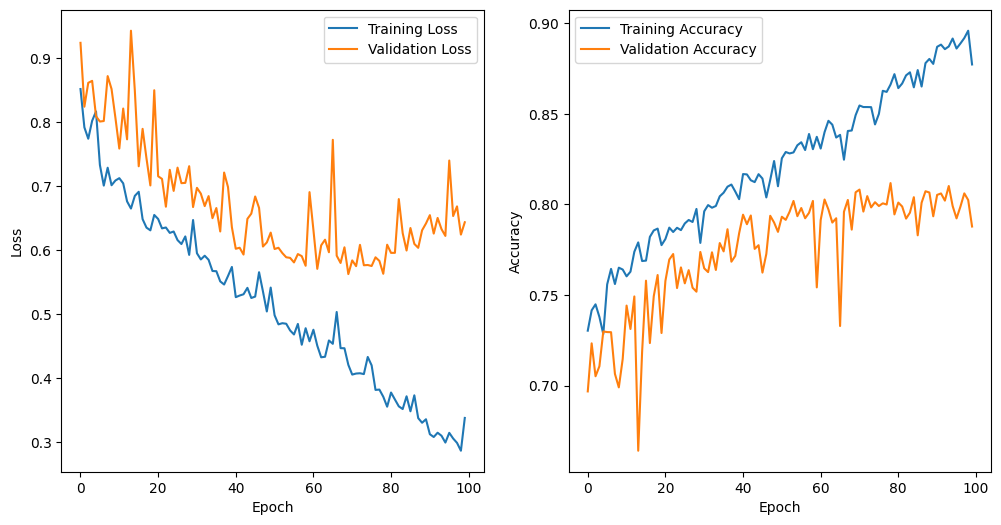

In [ ]:
# visualisasi data
import matplotlib.pyplot as plt

# plotting figure loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# plotting figure accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

Prediksi

In [ ]:
pip install rasterio

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
import rasterio
from PIL import Image
from rasterio.features import shapes
import geopandas as gpd
from shapely.geometry import shape

In [ ]:
# Mapping warna ke kelas (untuk visualisasi)
COLOR_MAP = {
    (0, 255, 255): 0,  # urban_land
    (255, 255, 0): 1,  # agriculture_land
    (255, 0, 255): 2,  # rangeland
    (0, 255, 0): 3,    # forest_land
    (0, 0, 255): 4,    # water
    (255, 255, 255): 5,  # barren_land
    (0, 0, 0): 6       # unknown
}


In [ ]:
# Mapping kelas ke nama label (untuk atribut Shapefile)
CLASS_LABELS = {
    0: "urban_land",
    1: "agriculture_land",
    2: "rangeland",
    3: "forest_land",
    4: "water",
    5: "barren_land",
    6: "unknown"
}


Ukuran gambar (PIL): (1849, 980)
Dimensi gambar (PIL): (980, 1849, 4)
Dimensi gambar asli (RGB, rasterio): 980x1849x3


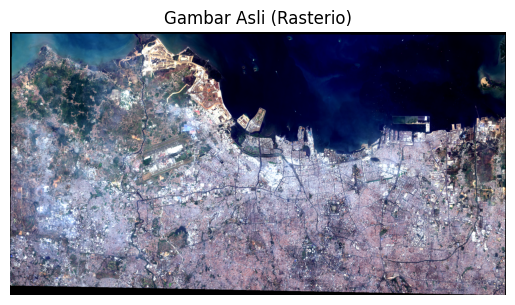

In [ ]:

# Fungsi untuk mengonversi kelas ke warna (untuk visualisasi)
def class_to_color(class_mask, color_map):
    color_image = np.zeros((class_mask.shape[0], class_mask.shape[1], 3), dtype=np.uint8)
    for color, class_id in color_map.items():
        color_image[class_mask == class_id] = color
    return color_image

# Path input dan output
image_path = '/content/drive/MyDrive/UNet/data.tif'
output_shp_path = '/content/drive/MyDrive/UNet/shapefile/result.shp'

# Verifikasi gambar dengan PIL (opsional)
img_pil = Image.open(image_path)
print("Ukuran gambar (PIL):", img_pil.size)  # (lebar, tinggi)
img_array_pil = np.array(img_pil)
print("Dimensi gambar (PIL):", img_array_pil.shape)  # (tinggi, lebar, channels)

# Langkah 1: Load gambar asli tanpa resize dengan rasterio
with rasterio.open(image_path) as src:
    img_array = src.read()  # Baca semua band
    img_array = img_array.transpose(1, 2, 0)  # Ubah ke (height, width, channels)
    transform = src.transform  # Simpan transform untuk georeferensi
    crs = src.crs  # Simpan CRS untuk Shapefile

# Ambil hanya 3 band pertama (RGB) dan normalisasi
img_array_rgb = img_array[:, :, :3] / 255.0  # Ambil band 0, 1, 2 (RGB)
height, width = img_array_rgb.shape[0], img_array_rgb.shape[1]
print(f"Dimensi gambar asli (RGB, rasterio): {height}x{width}x3")

# Tampilkan gambar asli untuk verifikasi
img = Image.fromarray((img_array_rgb * 255).astype(np.uint8))
plt.imshow(img)
plt.title("Gambar Asli (Rasterio)")
plt.axis('off')
plt.show()


In [ ]:
# Load model (ganti path model sesuai lokasi Anda)
model_loaded = load_model('/content/drive/MyDrive/UNet/model/best_model_unet_optimasi.h5')

In [ ]:

# Ukuran tile yang diharapkan model
tile_size = 256
# Inisialisasi array untuk menyimpan hasil prediksi dengan ukuran asli
pred_classes_full = np.zeros((height, width), dtype=np.uint8)


In [ ]:

# Langkah 2: Proses gambar dalam tiles
for y in range(0, height, tile_size):
    for x in range(0, width, tile_size):
        # Tentukan batas tile
        y_end = min(y + tile_size, height)
        x_end = min(x + tile_size, width)
        tile_height = y_end - y
        tile_width = x_end - x

        # Ambil tile dari gambar asli (RGB)
        tile = img_array_rgb[y:y_end, x:x_end, :]

        # Jika tile lebih kecil dari 256x256, pad dengan nol
        if tile_height < tile_size or tile_width < tile_size:
            tile_padded = np.zeros((tile_size, tile_size, 3), dtype=np.float32)
            tile_padded[:tile_height, :tile_width, :] = tile
        else:
            tile_padded = tile

        # Tambahkan dimensi batch
        tile_input = np.expand_dims(tile_padded, axis=0)  # (1, 256, 256, 3)

        # Prediksi untuk tile
        pred_tile = model_loaded.predict(tile_input, verbose=0)
        pred_classes_tile = np.argmax(pred_tile, axis=-1)[0]  # (256, 256)

        # Potong hasil prediksi sesuai ukuran tile asli
        pred_classes_full[y:y_end, x:x_end] = pred_classes_tile[:tile_height, :tile_width]



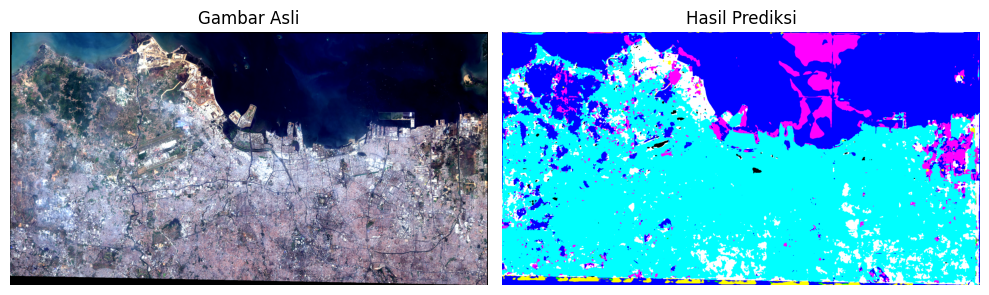

In [ ]:
# Langkah 3: Visualisasi hasil prediksi
pred_colored = class_to_color(pred_classes_full, COLOR_MAP)
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title("Gambar Asli")
plt.axis("off")
plt.subplot(1, 2, 2)
plt.imshow(pred_colored)
plt.title("Hasil Prediksi")
plt.axis("off")
plt.tight_layout()
plt.show()

In [ ]:
# Langkah 4: Konversi raster ke poligon
shapes_gen = shapes(pred_classes_full, transform=transform)

# Buat list untuk menyimpan geometri dan atribut
geometries = []
labels = []

for geom, value in shapes_gen:
    geometries.append(shape(geom))  # Konversi ke shapely geometry
    labels.append(CLASS_LABELS[int(value)])  # Ambil nama label dari kelas

# Buat GeoDataFrame awal
gdf = gpd.GeoDataFrame({
    'geometry': geometries,
    'label_name': labels
})



In [ ]:
# Langkah 5: Gabungkan poligon berdasarkan label_name
gdf_dissolved = gdf.dissolve(by='label_name', aggfunc='first').reset_index()

# Set CRS dari file asli
gdf_dissolved.crs = crs

In [ ]:
# Simpan ke Shapefile
gdf_dissolved.to_file(output_shp_path)
print(f"Hasil prediksi kelas disimpan sebagai Shapefile di: {output_shp_path}")
print(f"Jumlah kategori unik di Shapefile: {len(gdf_dissolved)}")


Hasil prediksi kelas disimpan sebagai Shapefile di: /content/drive/MyDrive/UNet/shapefile/result.shp
Jumlah kategori unik di Shapefile: 7


Evaluasi

IOU

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.metrics import MeanIoU
import matplotlib.pyplot as plt



def calculate_iou_metrics(model, x_data, y_data, num_classes=7):
    """
    Menghitung IoU metrics dari model segmentasi land cover

    Parameters:
        model: Model Keras yang sudah dilatih
        x_data: Data input gambar
        y_data: Data ground truth label (dengan format [..., 1])
        num_classes: Jumlah kelas dalam segmentasi

    Returns:
        Dictionary berisi mean_iou dan iou_per_class
    """
    # Prediksi model
    y_pred = model.predict(x_data)

    # Mengonversi prediksi ke indeks kelas
    if len(y_pred.shape) == 4 and y_pred.shape[-1] > 1:  # Output model adalah one-hot encoding
        y_pred = np.argmax(y_pred, axis=-1)

    # Mengonversi y_true ke format yang tepat
    y_true = np.squeeze(y_data)  # Menghilangkan dimensi channel terakhir

    # 1. Menggunakan metrik Keras MeanIoU
    m = MeanIoU(num_classes=num_classes)
    m.update_state(y_true, y_pred)
    mean_iou_keras = m.result().numpy()

    # 2. Menghitung IoU per kelas secara manual
    class_iou = []
    class_names = ["urban_land", "agriculture_land", "rangeland", "forest_land", "water", "barren_land", "unknown"]

    for class_id in range(num_classes):
        # Menghitung IoU untuk setiap kelas secara manual
        true_class = (y_true == class_id).astype(np.int32)
        pred_class = (y_pred == class_id).astype(np.int32)

        # True Positive (TP)
        tp = np.sum(true_class * pred_class)
        # False Positive (FP)
        fp = np.sum(pred_class) - tp
        # False Negative (FN)
        fn = np.sum(true_class) - tp

        # IoU = TP / (TP + FP + FN)
        if tp + fp + fn > 0:
            iou = tp / (tp + fp + fn)
        else:
            iou = 0.0

        class_iou.append(iou)

    # Menghitung mean IoU dari semua kelas
    mean_iou_manual = np.mean(class_iou)

    # Membuat hasil dalam format yang mudah dibaca
    results = {
        "mean_iou_keras": mean_iou_keras,
        "mean_iou_manual": mean_iou_manual,
        "class_iou": {class_names[i]: class_iou[i] for i in range(num_classes)},
        "class_iou_values": class_iou
    }

    return results

def print_iou_results(model, X_valid, Y_valid, num_classes=7):
    """
    Mencetak hasil evaluasi IoU dengan format yang rapi
    """
    results = calculate_iou_metrics(model, X_valid, Y_valid, num_classes)

    print("=" * 50)
    print("HASIL EVALUASI IoU")
    print("=" * 50)
    print(f"Mean IoU (Keras): {results['mean_iou_keras']:.4f}")
    print(f"Mean IoU (Manual): {results['mean_iou_manual']:.4f}")
    print("\nIoU per kelas:")
    print("-" * 50)

    for class_name, iou in results['class_iou'].items():
        print(f"{class_name:<15}: {iou:.4f}")

    # Hitung akurasi kelas yang bagus (IoU > 0.5) dan buruk (IoU < 0.3)
    good_classes = [name for name, iou in results['class_iou'].items() if iou > 0.5]
    poor_classes = [name for name, iou in results['class_iou'].items() if iou < 0.3]

    print("\nAnalisis:")
    if good_classes:
        print(f"- Kelas dengan performa baik (IoU > 0.5): {', '.join(good_classes)}")
    if poor_classes:
        print(f"- Kelas dengan performa buruk (IoU < 0.3): {', '.join(poor_classes)}")

    # Visualisasi IoU per kelas dengan bar chart
    plt.figure(figsize=(12, 6))
    plt.bar(results['class_iou'].keys(), results['class_iou'].values())
    plt.title('IoU per Kelas Land Cover')
    plt.xlabel('Kelas')
    plt.ylabel('IoU')
    plt.ylim(0, 1.0)
    plt.xticks(rotation=45)
    for i, v in enumerate(results['class_iou'].values()):
        plt.text(i, v + 0.02, f"{v:.3f}", ha='center')
    plt.tight_layout()
    plt.show()

    print("=" * 50)

    return results

def visualize_predictions(model, X_sample, Y_sample, num_samples=3, num_classes=7):
    """
    Visualisasi hasil prediksi model dibandingkan dengan ground truth
    """
    if num_samples > len(X_sample):
        num_samples = len(X_sample)

    # Warna untuk visualisasi mask
    colors = [
        [0, 255, 255],    # urban_land - cyan
        [255, 255, 0],    # agriculture_land - yellow
        [255, 0, 255],    # rangeland - magenta
        [0, 255, 0],      # forest_land - green
        [0, 0, 255],      # water - blue
        [255, 255, 255],  # barren_land - white
        [0, 0, 0]         # unknown - black
    ]

    class_names = ["urban_land", "agriculture_land", "rangeland", "forest_land", "water", "barren_land", "unknown"]

    # Prediksi model
    predictions = model.predict(X_sample[:num_samples])
    if len(predictions.shape) == 4 and predictions.shape[-1] > 1:
        predictions = np.argmax(predictions, axis=-1)

    # Ground truth
    ground_truth = np.squeeze(Y_sample[:num_samples])

    plt.figure(figsize=(15, 5 * num_samples))

    for i in range(num_samples):
        # Original image
        plt.subplot(num_samples, 3, i*3 + 1)
        plt.imshow(X_sample[i])
        plt.title('Original Image')
        plt.axis('off')

        # Ground truth
        plt.subplot(num_samples, 3, i*3 + 2)
        mask_vis = np.zeros((*ground_truth[i].shape, 3), dtype=np.uint8)
        for class_id, color in enumerate(colors):
            mask_vis[ground_truth[i] == class_id] = color
        plt.imshow(mask_vis)
        plt.title('Ground Truth')
        plt.axis('off')

        # Prediction
        plt.subplot(num_samples, 3, i*3 + 3)
        pred_vis = np.zeros((*predictions[i].shape, 3), dtype=np.uint8)
        for class_id, color in enumerate(colors):
            pred_vis[predictions[i] == class_id] = color
        plt.imshow(pred_vis)
        plt.title('Prediction')
        plt.axis('off')

    # Tambahkan legenda
    plt.figure(figsize=(10, 2))
    for i, (name, color) in enumerate(zip(class_names, colors)):
        plt.plot(0, 0, 's', color=[c/255 for c in color], label=name)
    plt.legend(loc='center', ncol=len(class_names))
    plt.axis('off')
    plt.tight_layout()
    plt.show()


5/5 ━━━━━━━━━━━━━━━━━━━━ 23s 371ms/step
HASIL EVALUASI IoU
Mean IoU (Keras): 0.5440
Mean IoU (Manual): 0.5440

IoU per kelas:
--------------------------------------------------
urban_land     : 0.6592
agriculture_land: 0.7876
rangeland      : 0.1894
forest_land    : 0.7174
water          : 0.6737
barren_land    : 0.4828
unknown        : 0.2976

Analisis:
- Kelas dengan performa baik (IoU > 0.5): urban_land, agriculture_land, forest_land, water
- Kelas dengan performa buruk (IoU < 0.3): rangeland, unknown


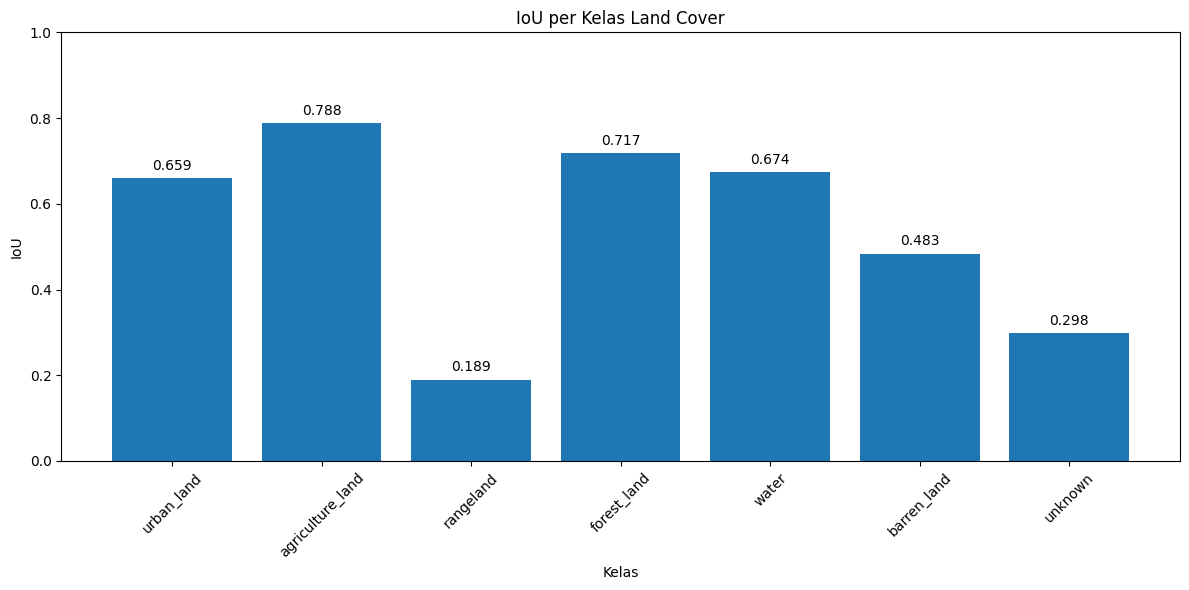

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


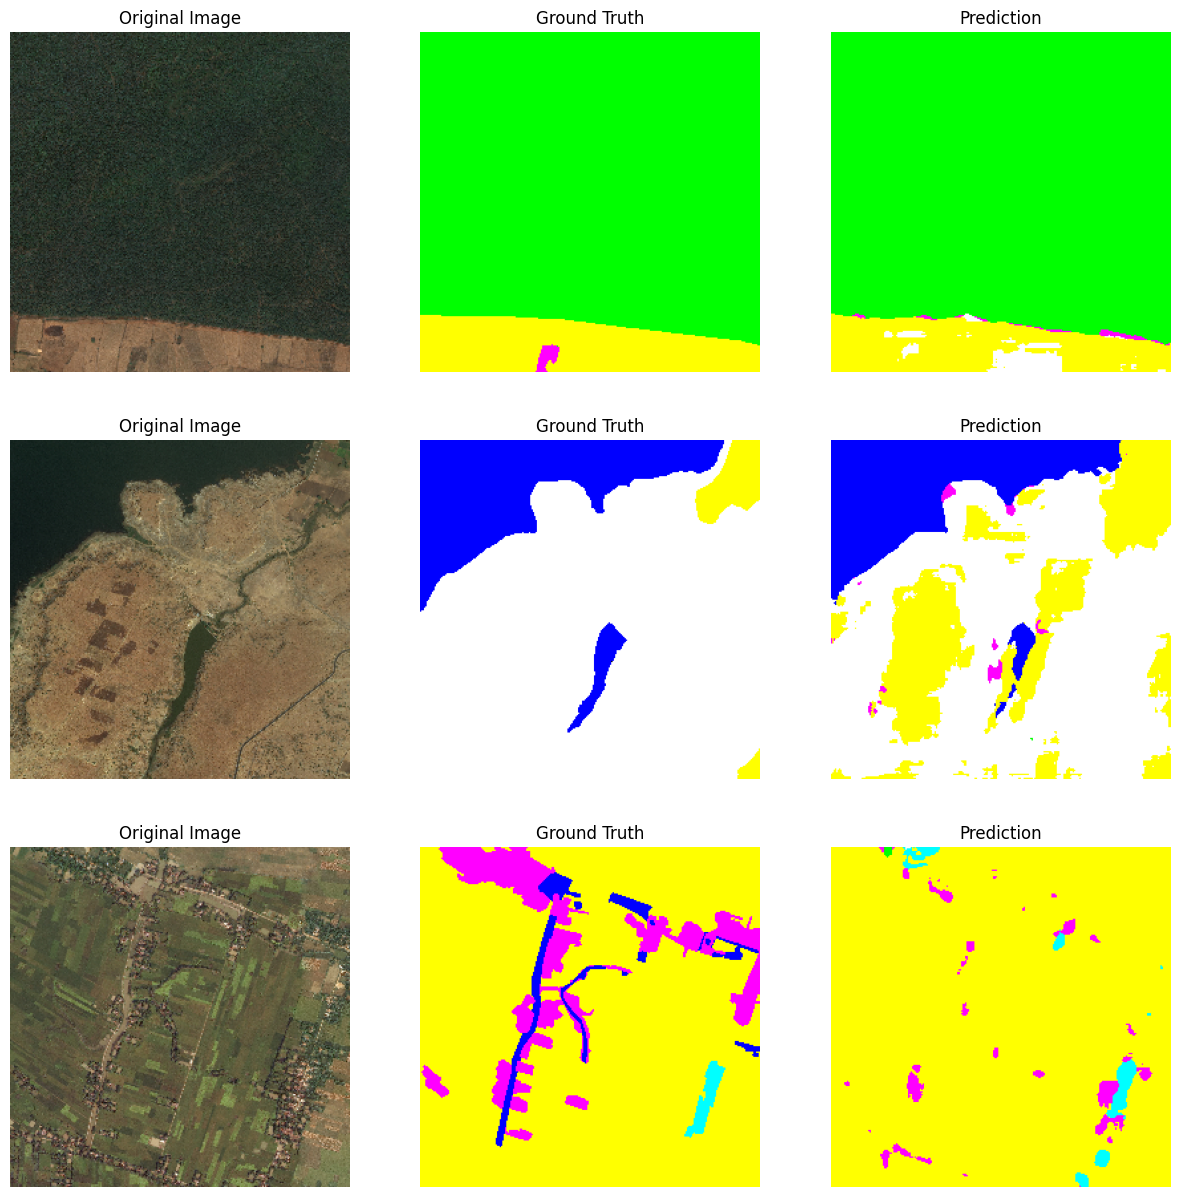

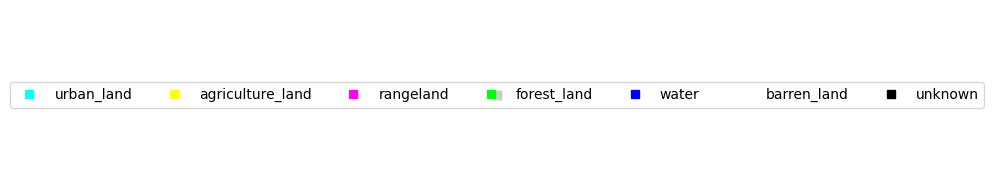

In [ ]:
hasil = print_iou_results(model_loaded, X_valid, Y_valid)
visualize_predictions(model_loaded, X_valid, Y_valid, num_samples=3)


Dice Coefficient

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

def calculate_dice_metrics(model, x_data, y_data, num_classes=7):
    """
    Menghitung Dice Coefficient untuk model segmentasi

    Parameters:
        model: Model Keras yang sudah dilatih
        x_data: Data input gambar
        y_data: Data ground truth label (dengan format [..., 1])
        num_classes: Jumlah kelas dalam segmentasi

    Returns:
        Dictionary berisi mean_dice dan metrics per kelas
    """
    # Prediksi model
    y_pred = model.predict(x_data)

    # Mengonversi prediksi ke indeks kelas
    if len(y_pred.shape) == 4 and y_pred.shape[-1] > 1:
        y_pred = np.argmax(y_pred, axis=-1)

    # Mengonversi y_true ke format yang tepat
    y_true = np.squeeze(y_data)

    # Menghitung Dice per kelas secara manual
    class_dice = []
    class_names = ["urban_land", "agriculture_land", "rangeland", "forest_land", "water", "barren_land", "unknown"]

    for class_id in range(num_classes):
        true_class = (y_true == class_id).astype(np.int32)
        pred_class = (y_pred == class_id).astype(np.int32)

        # True Positive (TP)
        tp = np.sum(true_class * pred_class)
        # False Positive (FP)
        fp = np.sum(pred_class) - tp
        # False Negative (FN)
        fn = np.sum(true_class) - tp

        # Dice Coefficient = 2*TP / (2*TP + FP + FN)
        if 2*tp + fp + fn > 0:
            dice = 2*tp / (2*tp + fp + fn)
        else:
            dice = 0.0

        class_dice.append(dice)

    # Menghitung mean dice
    mean_dice = np.mean(class_dice)

    # Membuat hasil
    results = {
        "mean_dice": mean_dice,
        "class_dice": {class_names[i]: class_dice[i] for i in range(num_classes)},
        "class_dice_values": class_dice
    }

    return results

def print_dice_results(model, X_valid, Y_valid, num_classes=7):
    """
    Mencetak hasil evaluasi Dice Coefficient dengan format yang rapi
    """
    results = calculate_dice_metrics(model, X_valid, Y_valid, num_classes)

    print("=" * 60)
    print("HASIL EVALUASI DICE COEFFICIENT")
    print("=" * 60)
    print(f"Mean Dice Coefficient: {results['mean_dice']:.4f}")

    print("\nDice Coefficient per kelas:")
    print("-" * 60)
    print(f"{'Kelas':<15} {'Dice':<10}")
    print("-" * 60)

    for class_name in results['class_dice'].keys():
        dice = results['class_dice'][class_name]
        print(f"{class_name:<15} {dice:.4f}")

    # Analisis performa
    good_classes = [name for name, dice in results['class_dice'].items() if dice > 0.5]
    poor_classes = [name for name, dice in results['class_dice'].items() if dice < 0.3]

    print("\nAnalisis:")
    if good_classes:
        print(f"- Kelas dengan performa baik (Dice > 0.5): {', '.join(good_classes)}")
    if poor_classes:
        print(f"- Kelas dengan performa buruk (Dice < 0.3): {', '.join(poor_classes)}")

    # Visualisasi
    plt.figure(figsize=(10, 6))
    plt.bar(results['class_dice'].keys(), results['class_dice'].values())
    plt.title('Dice Coefficient per Kelas')
    plt.xlabel('Kelas')
    plt.ylabel('Dice Coefficient')
    plt.ylim(0, 1.0)
    plt.xticks(rotation=45)
    for i, v in enumerate(results['class_dice'].values()):
        plt.text(i, v + 0.02, f"{v:.3f}", ha='center')

    plt.tight_layout()
    plt.show()

    print("=" * 60)

    return results

# Fungsi visualize_sample_predictions tetap sama
def visualize_sample_predictions(model, X_sample, Y_sample, num_samples=3, num_classes=7):
    """
    Visualisasi hasil prediksi model dibandingkan dengan ground truth
    """
    if num_samples > len(X_sample):
        num_samples = len(X_sample)

    colors = [
        [0, 255, 255],    # urban_land - cyan
        [255, 255, 0],    # agriculture_land - yellow
        [255, 0, 255],    # rangeland - magenta
        [0, 255, 0],      # forest_land - green
        [0, 0, 255],      # water - blue
        [255, 255, 255],  # barren_land - white
        [0, 0, 0]         # unknown - black
    ]

    class_names = ["urban_land", "agriculture_land", "rangeland", "forest_land", "water", "barren_land", "unknown"]

    if len(X_sample) > num_samples:
        indices = np.random.choice(len(X_sample), num_samples, replace=False)
        X_samples = X_sample[indices]
        Y_samples = Y_sample[indices]
    else:
        X_samples = X_sample[:num_samples]
        Y_samples = Y_sample[:num_samples]

    predictions = model.predict(X_samples)
    if len(predictions.shape) == 4 and predictions.shape[-1] > 1:
        predictions = np.argmax(predictions, axis=-1)

    ground_truth = np.squeeze(Y_samples)

    plt.figure(figsize=(15, 5 * num_samples))

    for i in range(num_samples):
        plt.subplot(num_samples, 3, i*3 + 1)
        plt.imshow(X_samples[i])
        plt.title('Original Image')
        plt.axis('off')

        plt.subplot(num_samples, 3, i*3 + 2)
        mask_vis = np.zeros((*ground_truth[i].shape, 3), dtype=np.uint8)
        for class_id, color in enumerate(colors):
            mask_vis[ground_truth[i] == class_id] = color
        plt.imshow(mask_vis)
        plt.title('Ground Truth')
        plt.axis('off')

        plt.subplot(num_samples, 3, i*3 + 3)
        pred_vis = np.zeros((*predictions[i].shape, 3), dtype=np.uint8)
        for class_id, color in enumerate(colors):
            pred_vis[predictions[i] == class_id] = color
        plt.imshow(pred_vis)
        plt.title('Prediction')
        plt.axis('off')

    plt.figure(figsize=(12, 2))
    for i, (name, color) in enumerate(zip(class_names, colors)):
        plt.plot(0, 0, 's', color=[c/255 for c in color], label=name)
    plt.legend(loc='center', ncol=len(class_names))
    plt.axis('off')
    plt.tight_layout()
    plt.show()


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 383ms/step
HASIL EVALUASI DICE COEFFICIENT
Mean Dice Coefficient: 0.6778

Dice Coefficient per kelas:
------------------------------------------------------------
Kelas           Dice      
------------------------------------------------------------
urban_land      0.7946
agriculture_land 0.8812
rangeland       0.3184
forest_land     0.8355
water           0.8050
barren_land     0.6512
unknown         0.4587

Analisis:
- Kelas dengan performa baik (Dice > 0.5): urban_land, agriculture_land, forest_land, water, barren_land


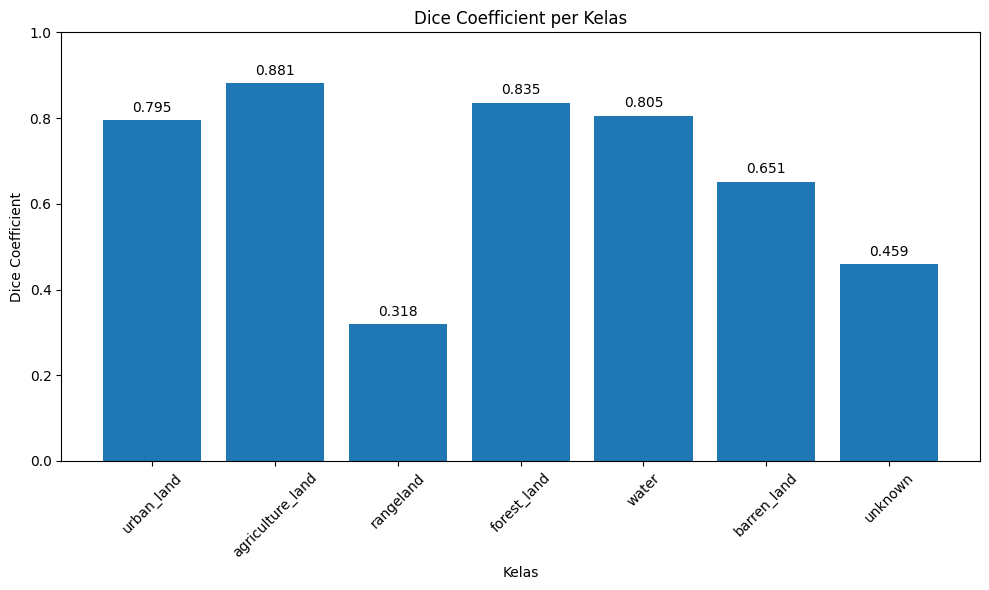

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


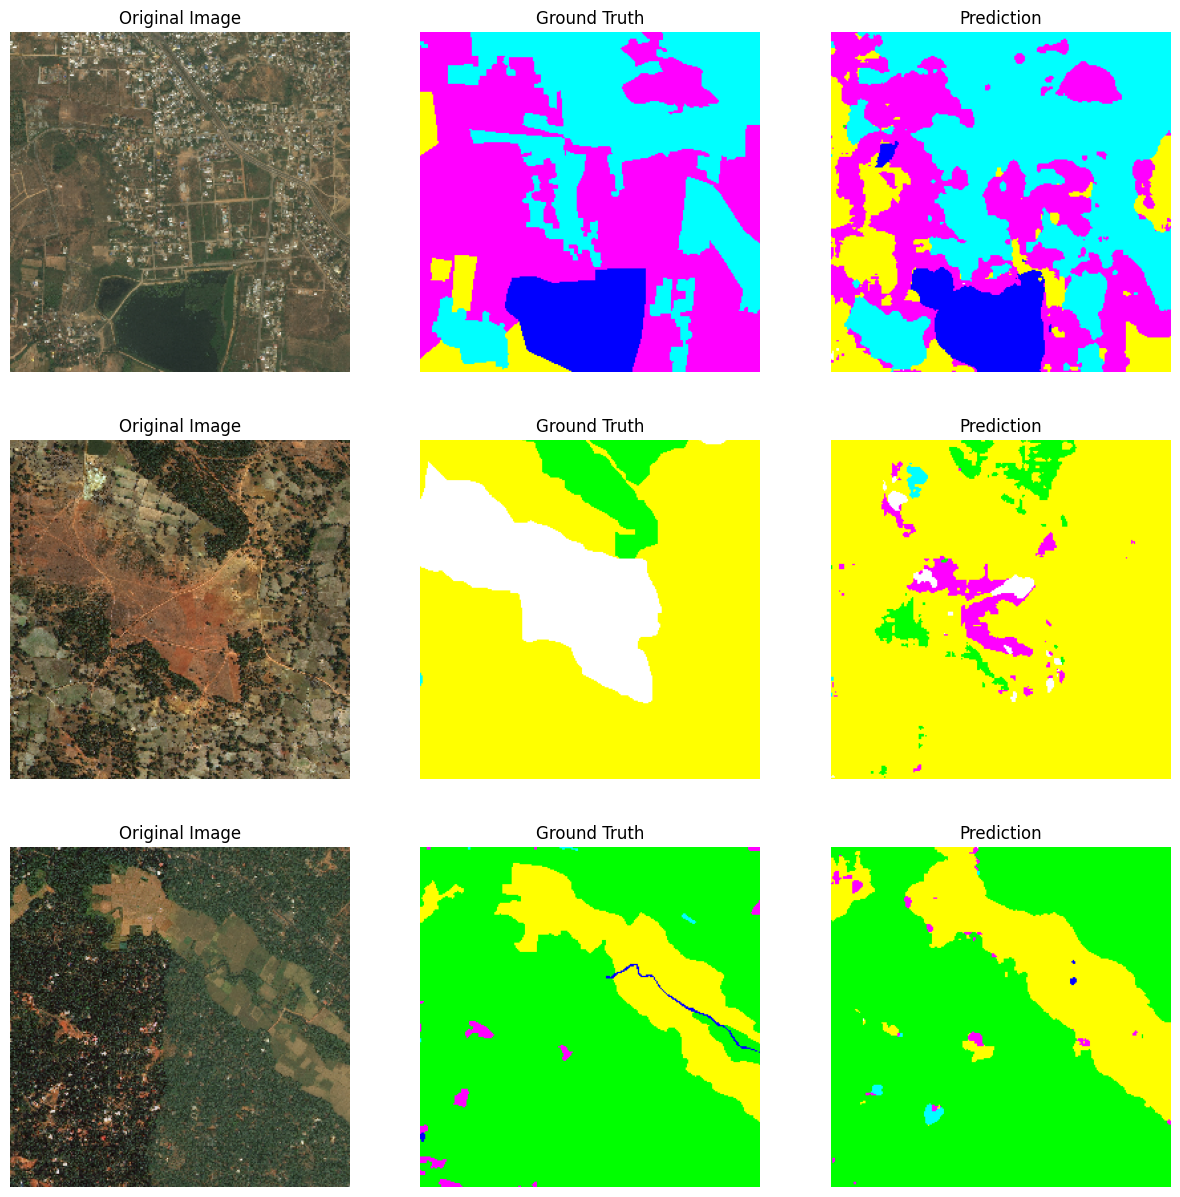

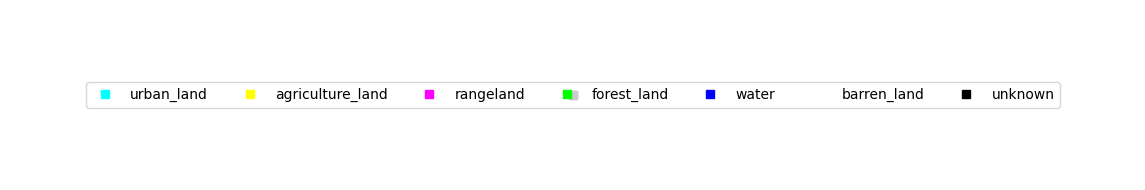

In [ ]:
# Cara menggunakan:
hasil_dice = print_dice_results(model_loaded, X_valid, Y_valid)
visualize_sample_predictions(model_loaded, X_valid, Y_valid, num_samples=3)


Pixel Accuracy

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

def calculate_pixel_accuracy(model, x_data, y_data, num_classes=7):
    """
    Menghitung Pixel Accuracy untuk model segmentasi

    Parameters:
        model: Model Keras yang sudah dilatih
        x_data: Data input gambar
        y_data: Data ground truth label (dengan format [..., 1])
        num_classes: Jumlah kelas dalam segmentasi

    Returns:
        Dictionary berisi overall_accuracy dan accuracy per kelas
    """
    # Prediksi model
    y_pred = model.predict(x_data)

    # Mengonversi prediksi ke indeks kelas
    if len(y_pred.shape) == 4 and y_pred.shape[-1] > 1:
        y_pred = np.argmax(y_pred, axis=-1)

    # Mengonversi y_true ke format yang tepat
    y_true = np.squeeze(y_data)

    # Menghitung overall pixel accuracy
    correct_pixels = np.sum(y_true == y_pred)
    total_pixels = y_true.size
    overall_accuracy = correct_pixels / total_pixels

    # Menghitung accuracy per kelas
    class_accuracy = []
    class_names = ["urban_land", "agriculture_land", "rangeland", "forest_land", "water", "barren_land", "unknown"]

    for class_id in range(num_classes):
        true_class = (y_true == class_id)
        pred_class = (y_pred == class_id)
        correct = np.sum(true_class & pred_class)
        total = np.sum(true_class)
        if total > 0:
            acc = correct / total
        else:
            acc = 0.0
        class_accuracy.append(acc)

    # Membuat hasil
    results = {
        "overall_accuracy": overall_accuracy,
        "class_accuracy": {class_names[i]: class_accuracy[i] for i in range(num_classes)},
        "class_accuracy_values": class_accuracy
    }

    return results

def print_accuracy_results(model, X_valid, Y_valid, num_classes=7):
    """
    Mencetak hasil evaluasi Pixel Accuracy dengan format yang rapi
    """
    results = calculate_pixel_accuracy(model, X_valid, Y_valid, num_classes)

    print("=" * 60)
    print("HASIL EVALUASI PIXEL ACCURACY")
    print("=" * 60)
    print(f"Overall Pixel Accuracy: {results['overall_accuracy']:.4f}")

    print("\nPixel Accuracy per kelas:")
    print("-" * 60)
    print(f"{'Kelas':<15} {'Accuracy':<10}")
    print("-" * 60)

    for class_name in results['class_accuracy'].keys():
        acc = results['class_accuracy'][class_name]
        print(f"{class_name:<15} {acc:.4f}")

    # Analisis performa
    good_classes = [name for name, acc in results['class_accuracy'].items() if acc > 0.7]
    poor_classes = [name for name, acc in results['class_accuracy'].items() if acc < 0.4]

    print("\nAnalisis:")
    if good_classes:
        print(f"- Kelas dengan performa baik (Accuracy > 0.7): {', '.join(good_classes)}")
    if poor_classes:
        print(f"- Kelas dengan performa buruk (Accuracy < 0.4): {', '.join(poor_classes)}")

    # Visualisasi
    plt.figure(figsize=(10, 6))
    plt.bar(results['class_accuracy'].keys(), results['class_accuracy'].values())
    plt.title('Pixel Accuracy per Kelas')
    plt.xlabel('Kelas')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1.0)
    plt.xticks(rotation=45)
    for i, v in enumerate(results['class_accuracy'].values()):
        plt.text(i, v + 0.02, f"{v:.3f}", ha='center')

    plt.tight_layout()
    plt.show()

    print("=" * 60)

    return results

def visualize_sample_predictions(model, X_sample, Y_sample, num_samples=3, num_classes=7):
    """
    Visualisasi hasil prediksi model dibandingkan dengan ground truth
    """
    if num_samples > len(X_sample):
        num_samples = len(X_sample)

    colors = [
        [0, 255, 255],    # urban_land - cyan
        [255, 255, 0],    # agriculture_land - yellow
        [255, 0, 255],    # rangeland - magenta
        [0, 255, 0],      # forest_land - green
        [0, 0, 255],      # water - blue
        [255, 255, 255],  # barren_land - white
        [0, 0, 0]         # unknown - black
    ]

    class_names = ["urban_land", "agriculture_land", "rangeland", "forest_land", "water", "barren_land", "unknown"]

    if len(X_sample) > num_samples:
        indices = np.random.choice(len(X_sample), num_samples, replace=False)
        X_samples = X_sample[indices]
        Y_samples = Y_sample[indices]
    else:
        X_samples = X_sample[:num_samples]
        Y_samples = Y_sample[:num_samples]

    predictions = model.predict(X_samples)
    if len(predictions.shape) == 4 and predictions.shape[-1] > 1:
        predictions = np.argmax(predictions, axis=-1)

    ground_truth = np.squeeze(Y_samples)

    plt.figure(figsize=(15, 5 * num_samples))

    for i in range(num_samples):
        plt.subplot(num_samples, 3, i*3 + 1)
        plt.imshow(X_samples[i])
        plt.title('Original Image')
        plt.axis('off')

        plt.subplot(num_samples, 3, i*3 + 2)
        mask_vis = np.zeros((*ground_truth[i].shape, 3), dtype=np.uint8)
        for class_id, color in enumerate(colors):
            mask_vis[ground_truth[i] == class_id] = color
        plt.imshow(mask_vis)
        plt.title('Ground Truth')
        plt.axis('off')

        plt.subplot(num_samples, 3, i*3 + 3)
        pred_vis = np.zeros((*predictions[i].shape, 3), dtype=np.uint8)
        for class_id, color in enumerate(colors):
            pred_vis[predictions[i] == class_id] = color
        plt.imshow(pred_vis)
        plt.title('Prediction')
        plt.axis('off')

    plt.figure(figsize=(12, 2))
    for i, (name, color) in enumerate(zip(class_names, colors)):
        plt.plot(0, 0, 's', color=[c/255 for c in color], label=name)
    plt.legend(loc='center', ncol=len(class_names))
    plt.axis('off')
    plt.tight_layout()
    plt.show()


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 357ms/step
HASIL EVALUASI PIXEL ACCURACY
Overall Pixel Accuracy: 0.8067

Pixel Accuracy per kelas:
------------------------------------------------------------
Kelas           Accuracy  
------------------------------------------------------------
urban_land      0.8056
agriculture_land 0.9278
rangeland       0.2542
forest_land     0.8528
water           0.7157
barren_land     0.5742
unknown         0.3489

Analisis:
- Kelas dengan performa baik (Accuracy > 0.7): urban_land, agriculture_land, forest_land, water
- Kelas dengan performa buruk (Accuracy < 0.4): rangeland, unknown


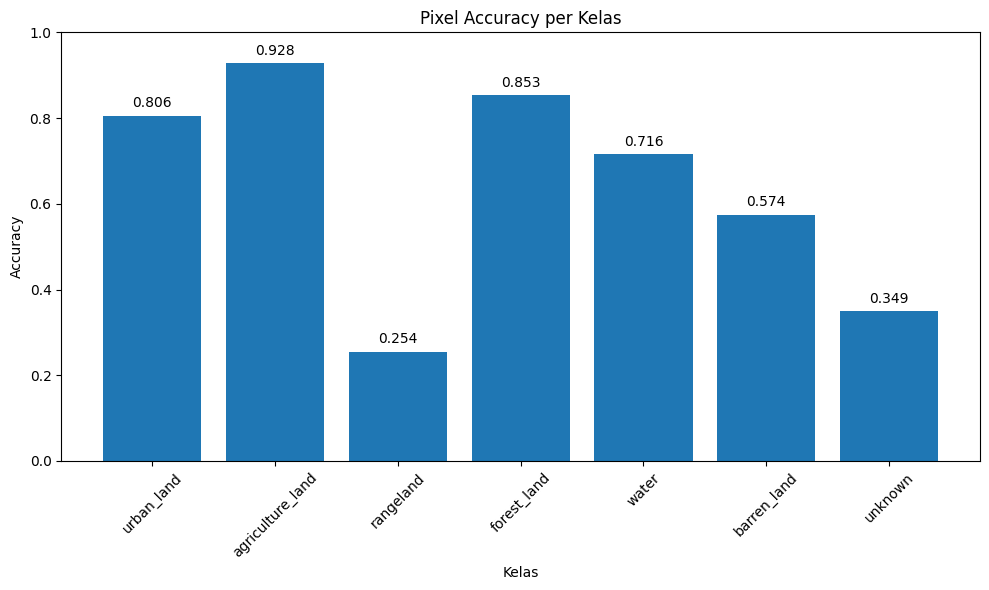

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


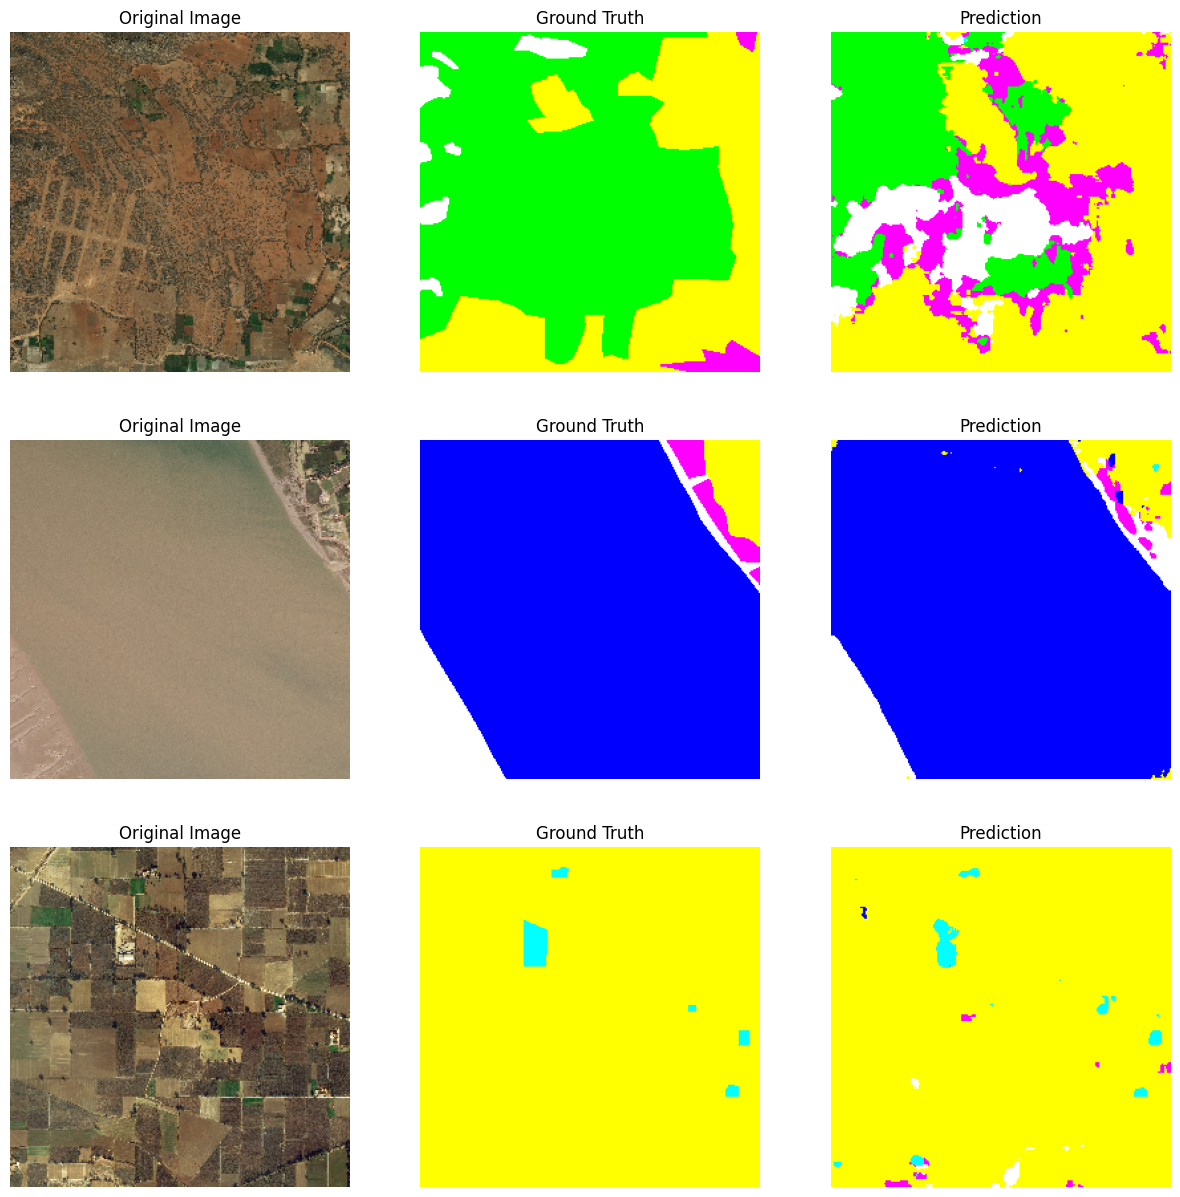

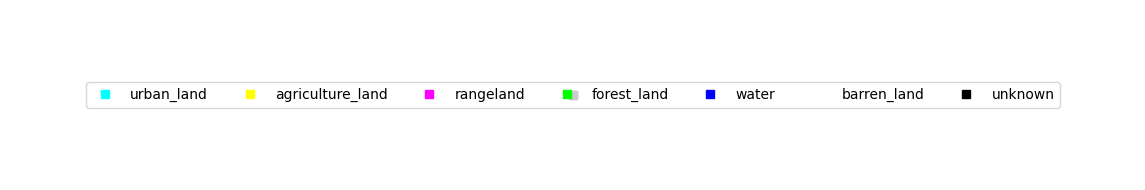

In [ ]:
hasil_pixel = print_accuracy_results(model_loaded, X_valid, Y_valid)
visualize_sample_predictions(model_loaded, X_valid, Y_valid, num_samples=3)